##  准备数据

四组服从动态分布的点：

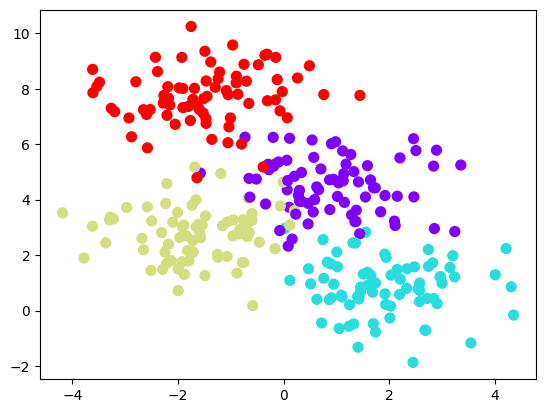

In [23]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

## 训练模型

训练模型，并可视化数据，用不同颜色表示标签不同的区域：

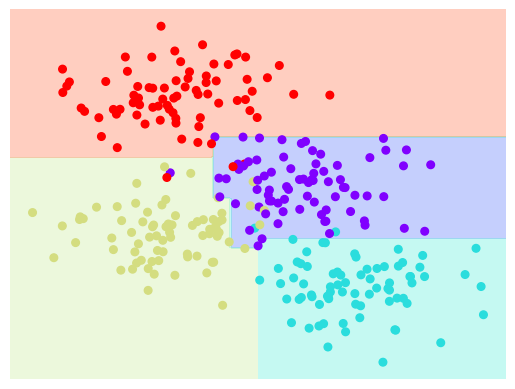

In [24]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # 绘制训练集数据点
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 模型拟合
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 填充结果区域
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

# 决策深度为5
visualize_classifier(DecisionTreeClassifier(max_depth=5), X, y)

决策树会沿着两个轴来分类数据，每一层的划分都会按照区域中大多数数据点的分类标签（多数票）来确定区域的标签值。为了进一步观察决策树的分类过程，下面的代码可以查看决策树五层的分类过程：

In [25]:
from ipywidgets import interact

def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()

    # 绘制训练数据点
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # 拟合评估器
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # 将结果放到颜色图表中
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

    # 绘制决策树边界
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_

            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]],
                        ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)

            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i],
                        tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])

    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5])


plot_tree_interactive(X, y)


interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

<function __main__.plot_tree_interactive.<locals>.interactive_tree(depth=5)>

随着深度（树节点层次）增加，我们会得到一个非常奇怪的分类区域形状；如上面深度为5时，图像下部会出现一条很高的狭长紫色区域，处于绿色和蓝色区域之间。从直觉上我们就可以知道这是错误的，这个结果不是来源自数据的内在分布特性，而更像是通过数据中个别的样本或噪音获得的。也就是说决策树即使只有5层深度也发生了数据的过拟合。



